In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (48, 48)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    'data/train',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    'data/test',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


In [4]:
# The original data set does not contain any test sets, so create one.
# Move 33% of validation set batches to test set.
number_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(number_batches // 3)
validation_dataset = validation_dataset.skip(number_batches // 3)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

# Configure the dataset for performance
# Use prefetching to prevent I/O from becoming blocking.
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Use data augmentation because dataset is not that large.
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)]
)

Number of validation batches: 150
Number of test batches: 75


In [5]:
# MobileNetV2
IMG_SHAPE = IMG_SIZE + (3,)
# Load MobileNetV2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

# Freeze convolutional base
base_model.trainable = False

# Convert elements to a single 1280-element vector per image
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

# Apply Dense layer to convert these features into 7 predictions per image.
prediction_layer = tf.keras.layers.Dense(7, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

# Build model by chaining the data augmentation, rescaling, base_model and feature extraction layers
inputs = tf.keras.Input(shape=(48, 48, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

nr_epochs = 20

(32, 2, 2, 1280)
(32, 1280)
(32, 7)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 48, 48, 3)         0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 2, 2, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)           

In [26]:
history = model.fit(train_dataset,
                    epochs=nr_epochs,
                    validation_data=validation_dataset)

loss, accuracy = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss))
print("initial accuracy: {:.2f}".format(accuracy))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Epoch 1/20
 46/898 [>.............................] - ETA: 1:17 - loss: 1.6468 - accuracy: 0.3349

KeyboardInterrupt: 

In [12]:
base_model.trainable = True

In [13]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [17]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 48, 48, 3)         0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 2, 2, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 7)                 8967  

In [18]:
len(model.trainable_variables)

56

In [21]:
fine_tune_epochs = 20
total_epochs =  20 + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 20/40
898/898 [==============================] - 72s 80ms/step - loss: 1.7326 - accuracy: 0.2923 - val_loss: 1.7186 - val_accuracy: 0.3024
Epoch 21/40
898/898 [==============================] - 71s 78ms/step - loss: 1.7205 - accuracy: 0.2986 - val_loss: 1.7050 - val_accuracy: 0.3137
Epoch 22/40
898/898 [==============================] - 71s 79ms/step - loss: 1.7153 - accuracy: 0.3011 - val_loss: 1.7048 - val_accuracy: 0.3188
Epoch 23/40
898/898 [==============================] - 71s 79ms/step - loss: 1.7076 - accuracy: 0.3076 - val_loss: 1.7333 - val_accuracy: 0.2853
Epoch 24/40
898/898 [==============================] - 72s 80ms/step - loss: 1.7048 - accuracy: 0.3121 - val_loss: 1.6890 - val_accuracy: 0.3236
Epoch 25/40
898/898 [==============================] - 72s 80ms/step - loss: 1.6987 - accuracy: 0.3125 - val_loss: 1.6806 - val_accuracy: 0.3265
Epoch 26/40
898/898 [==============================] - 71s 79ms/step - loss: 1.6903 - accuracy: 0.3185 - val_loss: 1.6745 - val_ac

In [22]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

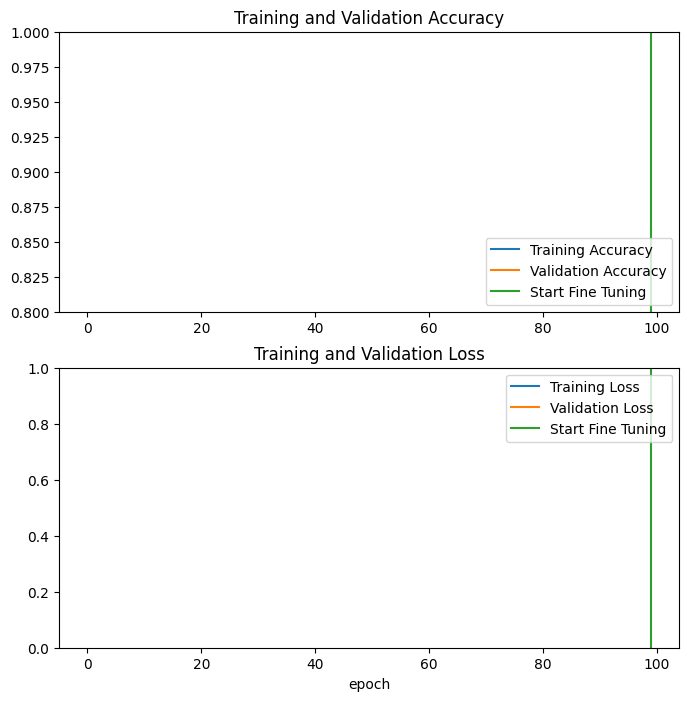

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([100-1,100-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([100-1,100-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
fine_acc = history_fine.history['accuracy']
fine_val_acc = history_fine.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
fine_loss = history_fine.history['loss']
fine_val_loss = history_fine.history['val_loss']

acc += fine_acc
val_acc += fine_val_acc

print(acc)
print(val_acc)

[0.1916472166776657, 0.21519383788108826, 0.2220209687948227, 0.22947508096694946, 0.2408304065465927, 0.24403497576713562, 0.25086209177970886, 0.25438016653060913, 0.26343655586242676, 0.2657703161239624, 0.26524782180786133, 0.2708558440208435, 0.269462525844574, 0.26925355195999146, 0.2723187804222107, 0.27709081768989563, 0.2764986455440521, 0.275906503200531, 0.27952906489372253, 0.276638001203537, 0.29231250286102295, 0.2985823154449463, 0.3010902404785156, 0.3076038956642151, 0.3120972514152527, 0.3124804198741913, 0.3185412287712097, 0.3212581276893616, 0.3212929666042328, 0.32613465189933777, 0.3257863521575928, 0.3271796405315399, 0.33452925086021423, 0.33115050196647644, 0.3346337378025055, 0.33421576023101807, 0.3348079025745392, 0.3372809886932373, 0.34017208218574524, 0.33909228444099426, 0.3440732955932617, 0.29231250286102295, 0.2985823154449463, 0.3010902404785156, 0.3076038956642151, 0.3120972514152527, 0.3124804198741913, 0.3185412287712097, 0.3212581276893616, 0.32

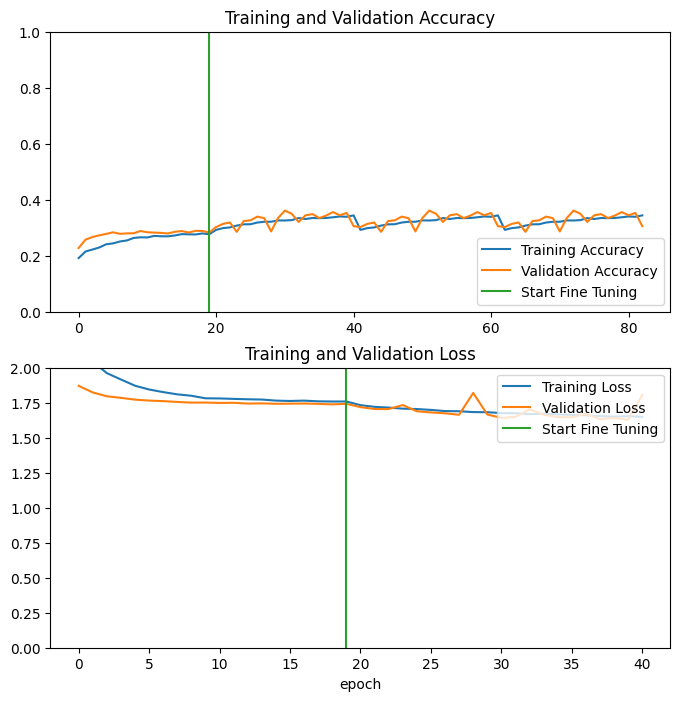

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([20-1,20-1],
          plt.ylim() + 1, label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([20-1,20-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()